# Causal Inference Using Pearl's Framework

## Objectives:

- Perform a causal inference task using Pearl’s framework;
- Infer the causal graph from observational data and then validate the graph;
- Merge machine learning with causal inference;


## Load Data and Libraries

In [2]:
# Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import causalnex
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
import os
import sys
from IPython.display import Image
import copy

import warnings
warnings.filterwarnings("ignore")


c:\Users\IRONMAN\miniconda3\envs\py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load Data

raw_df = pd.read_csv("../data/data.csv")
raw_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# Check Dataset

raw_df.shape

(569, 33)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### Observation
- There are 569 rows and 33 columns
- The last column is completely empty
- There is no Null value in any of the other columns.
- All the variables are float type except for the Id column and the diagnosis variable which is string.

## Clean Data

In [6]:
# removing null column and id
clean_df = raw_df.iloc[:,1:-1]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

### check for outliers

In [14]:
def check_outlier(df):
    tmp_info = df.describe()

    Q1 = np.array(tmp_info.iloc[4,:].values.flatten().tolist())
    Q3 = np.array(tmp_info.iloc[6,:].values.flatten().tolist())

    # calculate the Inerquartile range.
    IQR = Q3-Q1
    L_factor = IQR*1.5
    H_factor = IQR*3

    # Minor Outliers will lie outside the Inner fence
    Inner_Low = Q1-L_factor
    Inner_High = Q3 + L_factor
    inner_fence = [Inner_Low, Inner_High]

    # Major Outliers will lie outside the Outer fence
    Outer_Low = Q1-H_factor
    Outer_High = Q3+H_factor
    outer_fence = [Outer_Low, Outer_High]
    
    outliers = []
    for col_index in range(df.shape[1]):
        
        inner_count = 0
        outer_count = 0
        tmp_list = df.iloc[:,col_index].tolist()
        for value in tmp_list:
            if((value < inner_fence[0][col_index]) or (value > inner_fence[1][col_index])):
                inner_count = inner_count + 1
            elif((value < outer_fence[0][col_index]) or (value > outer_fence[1][col_index])):
                outer_count = outer_count + 1

        outliers.append({df.columns[col_index]:[inner_count, outer_count]})
    
    major_outlier = []
    minor_outlier = []
    columns = []
    outlier_dict = {}
    for item in outliers:
        columns.append(list(item.keys())[0])
        minor_outlier.append(list(item.values())[0][0])
        major_outlier.append(list(item.values())[0][1])

    outlier_dict["columns"] = columns
    outlier_dict["minor_outlier"] = minor_outlier
    outlier_dict["major_outlier"] = major_outlier
    outlier_df = pd.DataFrame(outlier_dict)

    return outlier_df
             


In [15]:
test = check_outlier(clean_df.iloc[:,1:])
test

,columns,minor_outlier,major_outlier
0,radius_mean,14,0
1,texture_mean,7,0
2,perimeter_mean,13,0
3,area_mean,25,0
4,smoothness_mean,6,0
5,compactness_mean,16,0
6,concavity_mean,18,0
7,concave points_mean,10,0
8,symmetry_mean,15,0
9,fractal_dimension_mean,15,0


### Observation
- There are no major outliers
- There are some minor outliers in each row
- There are no Null values

## Perform Exploratory Analysis

### Univariate Analysis

In [16]:
# Univariate Analysis
clean_df.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.000000,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.110000
texture_mean,569.000000,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.280000
perimeter_mean,569.000000,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.500000
area_mean,569.000000,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.000000
smoothness_mean,569.000000,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.163400
compactness_mean,569.000000,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.345400
concavity_mean,569.000000,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.426800
concave points_mean,569.000000,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.201200
symmetry_mean,569.000000,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.304000
fractal_dimension_mean,569.000000,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.097440


Number of Benign:  357
Number of Malignant :  212


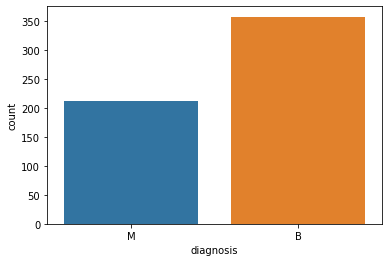

In [18]:
# check the target variable
target = clean_df["diagnosis"]
ax = sns.countplot(target,label="Count")       # M = 212, B = 357
B, M = target.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

### Observation
- Important summary statistics of all the numerical variables like the mean, std, min, 25%, 50%, 75%, and max values.
- There is high variation in values in area_mean and area_worst.
- There are many variables have median value 0.
- The area_worst feature’s max value is 4254 and fractal_dimension_se features’ max 0.029840. This indicates we need to standardize or normalize data before visualization, feature selection, and classification.
- Bar plot of diagnosis shows that Malignant and Benign patients ratio is 37% (212/569) and 63% (357/569) respectively.

In [24]:
def normalize(df):
  normald = Normalizer()
  normal = pd.DataFrame(normald.fit_transform(df))
  return normal

def scale(df):
  scaler = MinMaxScaler()
  scaled = pd.DataFrame(scaler.fit_transform(df))
  return scaled

def scale_and_normalize(df):
  columns = df.columns.to_list()
  normScaled = normalize(scale(df))
  normScaled.columns = columns
  return normScaled

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean'),
  Text(10, 0, 'radius_se'),
  Text(11, 0, 'texture_se'),
  Text(12, 0, 'perimeter_se'),
  Text(13, 0, 'area_se'),
  Text(14, 0, 'smoothness_se'),
  Text(15, 0, 'compactness_se'),
  Text(16, 0, 'concavity_se'),
  Text(17, 0, 'concave points_se'),
  Text(18, 0, 'symmetry_se'),
  Text(19, 0, 'fractal_dimension_se'),
  Text(20, 0, 'radius_worst'),
  Text(21, 0, 'texture_worst'),
  Text(22, 0, 'perimeter_worst'),
  Text(23, 0, 'area_worst'),
  Text(24, 0, 'smoothness_worst'),
  Text(25, 0, 'compactness_worst'),
  Text(26, 0, 'concavity_

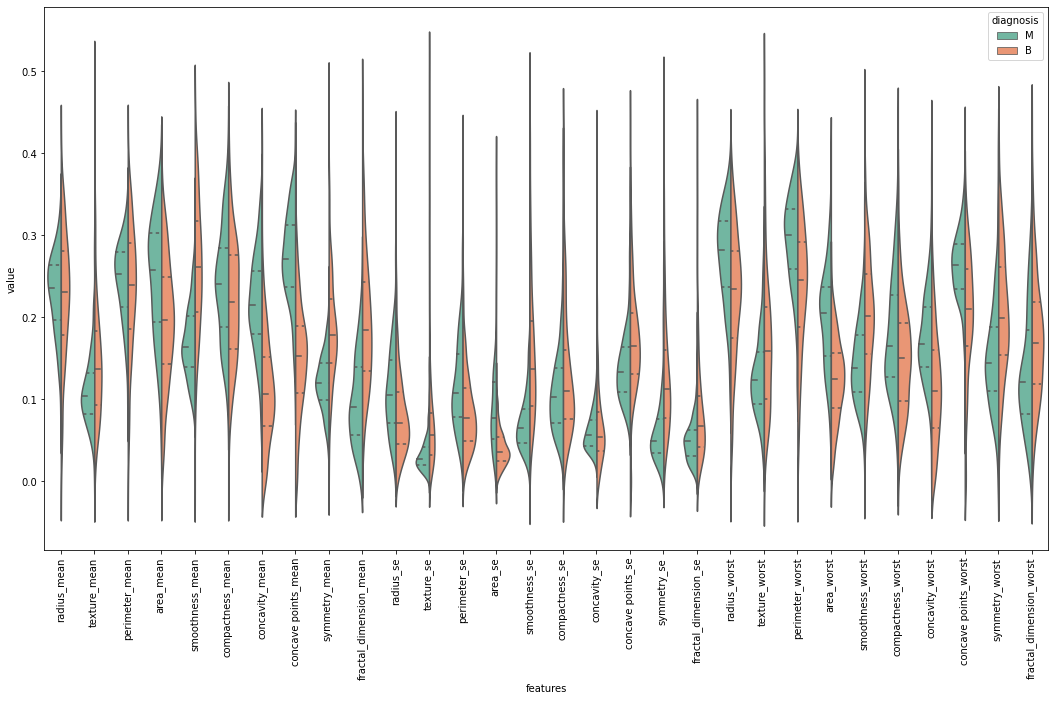

In [28]:
clean_df.iloc[:,1:] = scale_and_normalize(clean_df.iloc[:,1:]) 
data = pd.concat([clean_df.iloc[:,:]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(18,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart",palette ="Set2")
plt.xticks(rotation=90)

### Bivariate Analysis

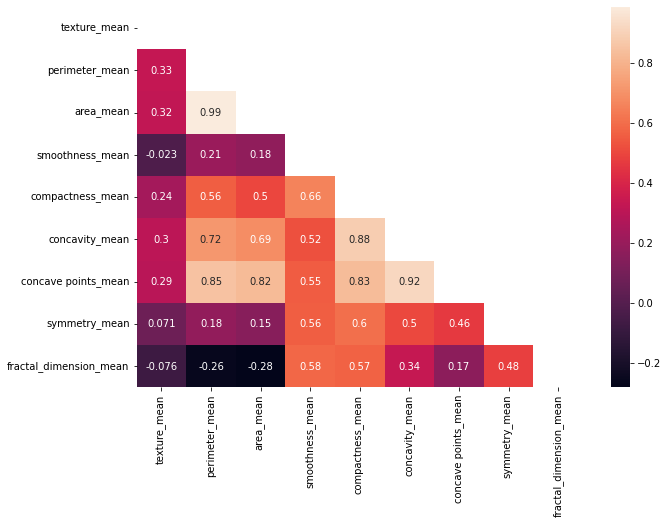

In [15]:
# bivariate Analysis
# correlation matrix
corr_matrix = scaled_df.iloc[:,1:].corr()
matrix = np.triu(corr_matrix)
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(corr_matrix, annot=True, mask=matrix)

### Observation
- The Distribution of the variables is right skewed
- There is a large correlation between radius and concave points, concavity and conpactness
- there is a large positive correlation between smoothness and compactness, fractal dimension.

## Discover Causal Graphs

In [17]:
# split the data 
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)
train_df = X_train.copy()
train_df["target"] = y_train

In [29]:
int(len(train_df)*0.2)

79

In [46]:
factor = len(train_df)/100
train_20 = train_df.sample(int(20*factor), random_state=11)
train_40 = train_df.sample(int(40*factor), random_state=11)
train_60 = train_df.sample(int(60*factor), random_state=11)
train_80 = train_df.sample(int(80*factor), random_state=11)
train_100 = train_df.copy()

In [118]:


def apply_treshold(sm, th):
  sm_copy = copy.deepcopy(sm)
  sm_copy.remove_edges_below_threshold(th)

  return sm_copy
  
def plot_graph(sm, th):
  tmp = apply_treshold(sm, th)
  viz = plot_structure(
      tmp,
      graph_attributes={"scale": "2.5", 'size': 2},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
  return Image(viz.draw(format='png'))

def jacc_index(sm1, sm2, th1, th2, formatted=True):
  sm1_copy = copy.deepcopy(sm1)
  sm2_copy = copy.deepcopy(sm2)
  sm1_copy.remove_edges_below_threshold(th1)
  sm2_copy.remove_edges_below_threshold(th2)
  a = sm1_copy.edges
  b = sm2_copy.edges
  n = set(a).intersection(b)
  sim = round(len(n) / (len(a) + len(b) - len(n)), 2)
  if(formatted):
    return f"The similarity index: {sim}"
  else:
    return sim 

In [74]:
ground_truth = from_pandas(train_df, tabu_parent_nodes=["target"])

In [78]:
# creating increasing proportion of original dataset.

sm20 = from_pandas(train_20, tabu_parent_nodes=["target"])
sm40 = from_pandas(train_40, tabu_parent_nodes=["target"])
sm60 = from_pandas(train_60, tabu_parent_nodes=["target"])
sm80 = from_pandas(train_80, tabu_parent_nodes=["target"])

## Evaluate Causal Graphs and Optimize

### check stabiliy

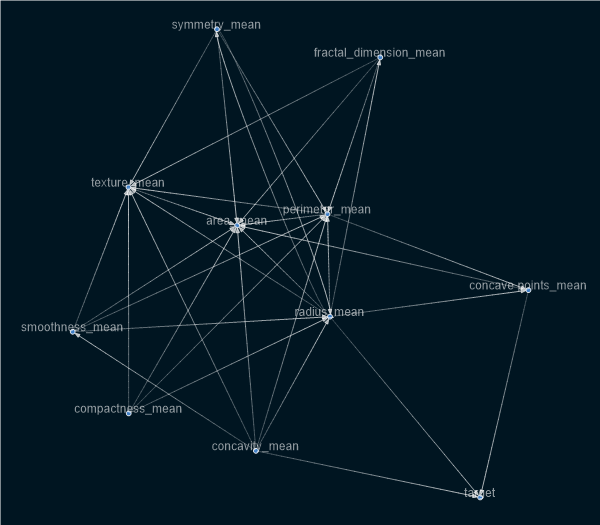

In [126]:
plot_graph(ground_truth, 0.3)

The similarity index: 0.67


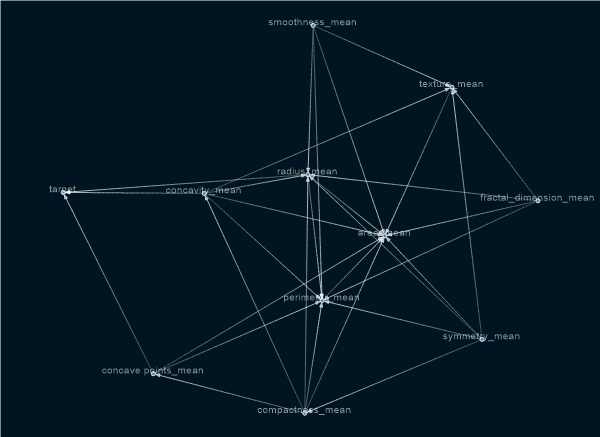

In [127]:
print(jacc_index(ground_truth,sm20, 0.3, 0.3))
plot_graph(sm20, 0.3)


The similarity index: 0.72


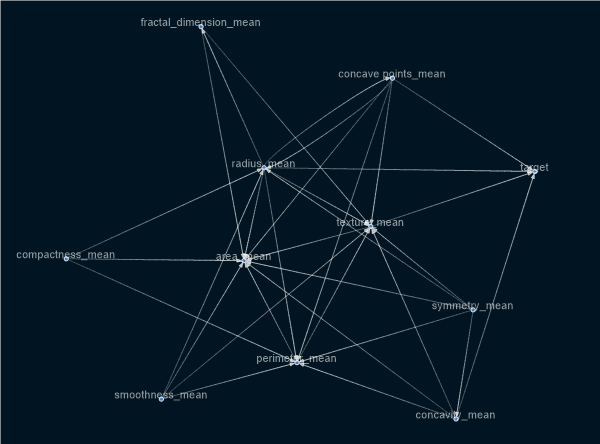

In [130]:
print(jacc_index(ground_truth,sm40, 0.3, 0.3))
plot_graph(sm40, 0.3)

The similarity index: 0.65


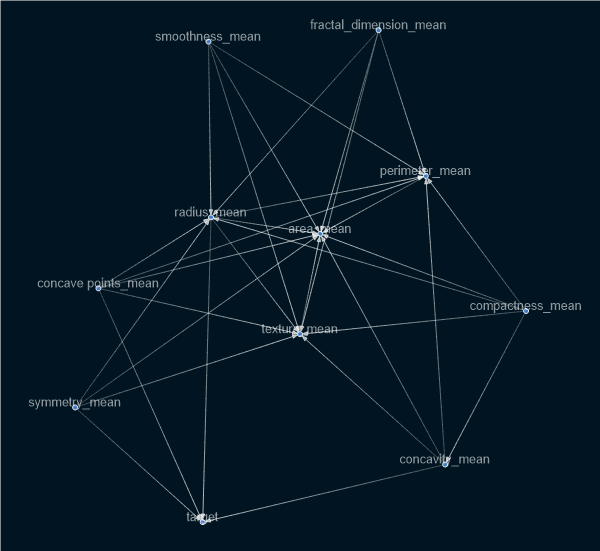

In [131]:
print(jacc_index(ground_truth,sm60, 0.3, 0.3))
plot_graph(sm60, 0.3)

The similarity index: 0.69


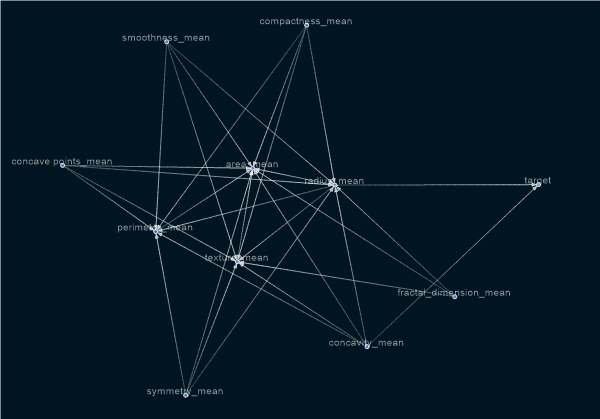

In [134]:
print(jacc_index(ground_truth,sm80, 0.3, 0.3))
plot_graph(sm80, 0.4)

### Observation
- the threshold value used is 0.3
- all graphs have similar relationship between target value and the others
- the general similarity index is above 60%

### select the markov blanket

In [152]:
sm_n = apply_treshold(ground_truth, 0.4)
blanket = sm_n.get_markov_blanket('target')
print(blanket.edges)

[('concave points_mean', 'target'), ('concavity_mean', 'radius_mean'), ('concavity_mean', 'target'), ('radius_mean', 'concave points_mean'), ('radius_mean', 'target')]


In [153]:
discretised_data = data.copy()
discretised_data[‘target’] = Discretiser(
    method=”fixed”,
    numeric_split_points = [-0.5, 1],
).transform(discretised_data[“target”].values)
target_map = {0: “Low”, 1: “Mid”, 2: ”High”}
discretised_data[‘target’] = (
    discretised_data[‘target’].map(target_map)
)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(
    discretised_data, 
    method=”BayesianEstimator”, 
    bayes_prior=”K2",
)
discretised_data.head()

causalnex.structure.structuremodel.StructureModel

## Model

In [ ]:
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(
    discretised_data, 
    method=”BayesianEstimator”, 
    bayes_prior=”K2",
)
discretised_data.head()

In [ ]:
from causalnex.inference import InferenceEngine
ie = InferenceEngine(bn)
observation_1 = {“age”: 2, “sex”: 1, “s3”: 3, “s5”: 0, “bmi”: 1}
observation_2 = {“age”: 1, “sex”: 1, “s3”: 2, “s5”: 0, “bmi”: 2}
marginals = ie.query([observation_1, observation_2])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_x, y, test_size=0.2, random_state=0)

In [ ]:
log_model = LogesticRegressionModel(X_train, X_test, y_train, y_test)
clf, log_acc_arr, log_loss_arr = log_model.train(folds = 2)

## Compare Models